# Controversial Game Updates vs. Player Engagement and Sentiment

### How do controversial updates or announcements affect player engagement and sentiment in popular online games?

I think this question has some good direction going for it. It's no surprise that players respond to game updates according to whether they like them or not, and this is no different. What I want to explore deeper is how drastically playercount and reviews are affected, and if there are any long term affects on a game's community.

A lot of data may end up being sourced from scraping instead of official APIs, but I'm willing to work with it for the sake of discovery!


In [43]:
# import some important libraries
import requests
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import urllib.parse
from scipy import stats
from numpy.ma.extras import average

### Exhibit A: Helldivers 2 PSN Controversy

This was kind of a no-brainer that this would receive some harsh backlash.

In [44]:
helldivers_csv = "Helldivers2PlayerCount.csv"
helldiversplayers_df = pd.read_csv(helldivers_csv)

helldiversplayers_df.fillna(0.0, inplace=True) # fill empty rows with 0s
helldiversplayers_df['DateTime'] = pd.to_datetime(helldiversplayers_df['DateTime']) # change it ro real datetime
helldiversplayers_df.set_index('DateTime', inplace=True)

print(helldiversplayers_df.head()) # proof

            Players  Average Players
DateTime                            
2017-08-14      6.0              0.0
2017-08-15      7.0              0.0
2017-08-16      5.0              0.0
2017-08-17      4.0              0.0
2017-08-18      7.0              0.0


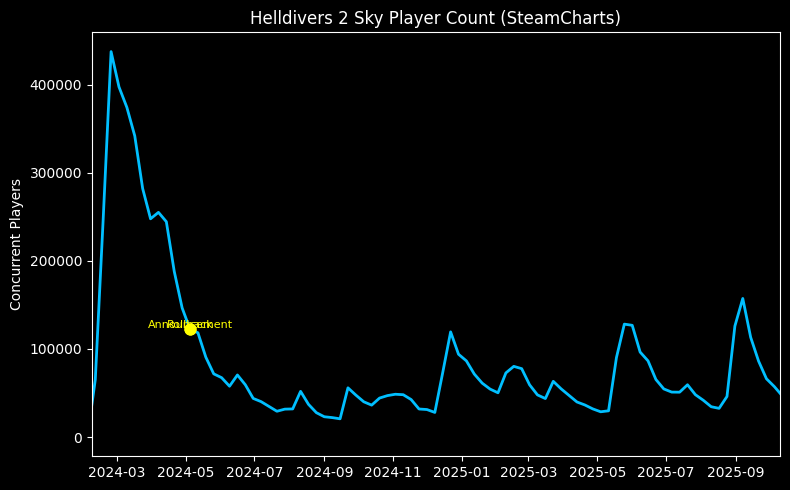

In [45]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title("Helldivers 2 Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")

# Zoom in on a date range — e.g., focus on the last 6–8 months
start = pd.Timestamp("2024-02-08")
end = pd.Timestamp("2025-10-10")
ax.set_xlim(start, end)

events = {
    "2024-05-03": "Announcement",
    "2024-05-06": "Rollback",
}

# Optionally smooth the data to reduce noise near the end
smooth = helldiversplayers_df.resample("W").mean()

event_dates = {pd.Timestamp(k): v for k, v in events.items()}

ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

for date, label in event_dates.items():
    # find nearest existing date in your index
    nearest = smooth.index[smooth.index.get_indexer([date], method="nearest")[0]]

    ax.scatter(nearest, smooth.loc[nearest, "Players"],
               color="yellow", s=60, zorder=5)

    # small text right above the point (optional)
    ax.text(nearest, smooth.loc[nearest, "Players"] + 2000,
            label, color="yellow", fontsize=8, ha="center")

plt.tight_layout()
plt.show()

Not as big of a plummet in players you would expect from the backlash. Let's try looking at a bigger range and some Steam reviews instead.

In [46]:
# pulled this csv from steamDB, so convenient that this data exists
helldivers_reviews_csv = "Helldivers2SteamCharts.csv"
helldivers_reviews_df = pd.read_csv(helldivers_reviews_csv)
helldivers_reviews_df.fillna(0.0, inplace=True) # fill empty rows with 0s
print(helldivers_reviews_df.head()) # proof


              DateTime  Positive reviews  Negative reviews
0  2024-02-09 00:00:00           11238.0           -4392.0
1  2024-02-10 00:00:00               0.0               0.0
2  2024-02-11 00:00:00            9522.0           -1589.0
3  2024-02-12 00:00:00               0.0               0.0
4  2024-02-13 00:00:00           10918.0           -3941.0


In [47]:

# Convert datetime column to pandas datetime
helldivers_reviews_df['DateTime'] = pd.to_datetime(helldivers_reviews_df['DateTime'])
reviews_df = helldivers_reviews_df.set_index("DateTime")

start_date = pd.Timestamp("2024-03-01")
end_date = pd.Timestamp("2024-08-01")
reviews_filtered = reviews_df.loc[start_date:end_date]

# change it to weekly
reviews_filtered = reviews_filtered.resample('W').sum()
reviews_filtered['Negative reviews'] = reviews_filtered['Negative reviews'].abs() # they're negative by default


# Calculate percentage positive
reviews_filtered['positive_percent'] = (reviews_filtered['Positive reviews'] / (reviews_filtered['Positive reviews'] + reviews_filtered['Negative reviews']) * 100)

reviews_filtered['negative_percent'] = (reviews_filtered['Negative reviews'] / (reviews_filtered['Negative reviews'] + reviews_filtered['Positive reviews']) * 100)

print(reviews_filtered.head())

            Positive reviews  Negative reviews  positive_percent  \
DateTime                                                           
2024-03-03           12017.0               0.0        100.000000   
2024-03-10           47731.0           10368.0         82.154598   
2024-03-17           29247.0            2038.0         93.485696   
2024-03-24           24229.0            2463.0         90.772516   
2024-03-31           23144.0            1490.0         93.951449   

            negative_percent  
DateTime                      
2024-03-03          0.000000  
2024-03-10         17.845402  
2024-03-17          6.514304  
2024-03-24          9.227484  
2024-03-31          6.048551  


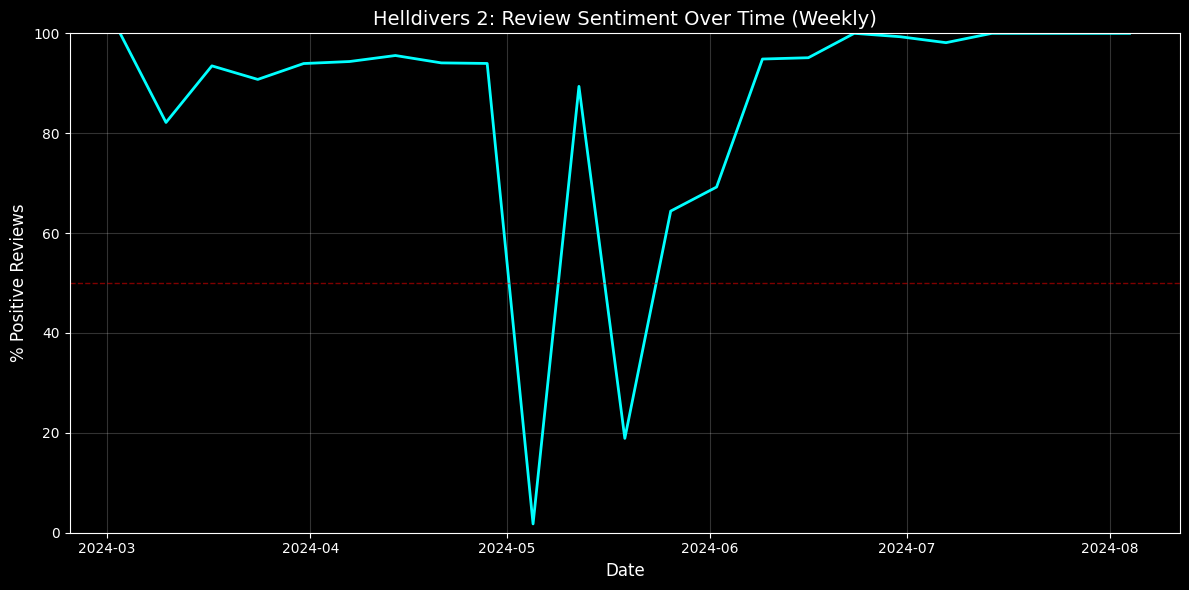

In [48]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(reviews_filtered.index, reviews_filtered['positive_percent'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Helldivers 2: Review Sentiment Over Time (Weekly)', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_4175/3656437920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_filtered['Positive reviews'] = close_filtered['Positive reviews'].replace(0, pos_avg)
/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_4175/3656437920.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_filtered['Negative reviews'] = close_filtered['Negative reviews'].replace(0, -neg_avg)
/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_4175/3656437

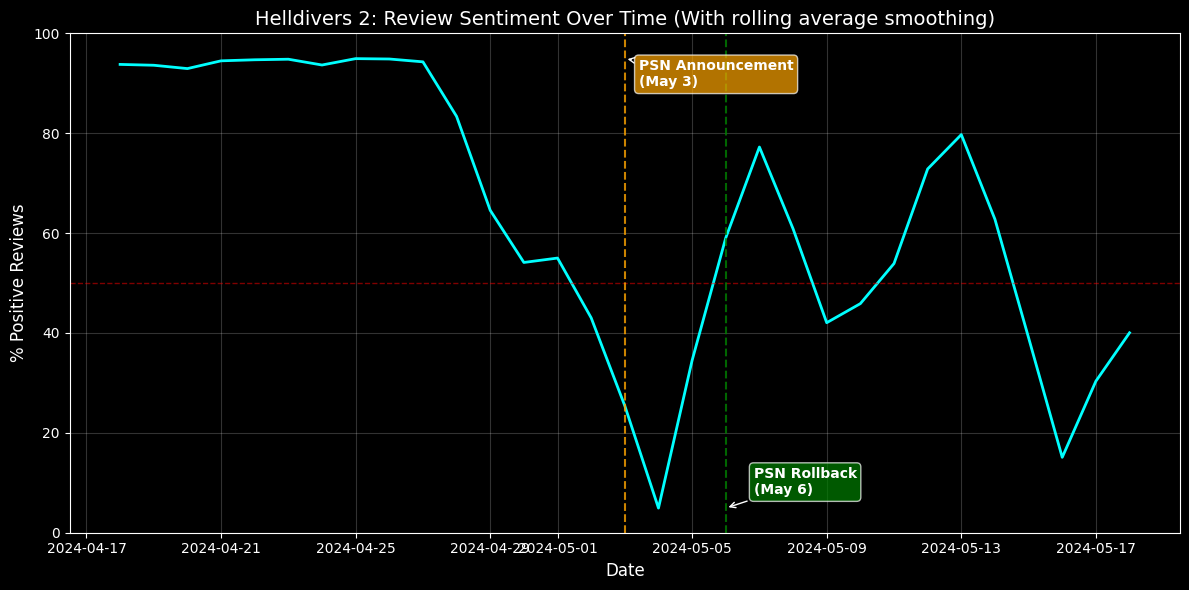

In [49]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))
# closer look
close_start = pd.Timestamp("2024-04-18")
close_end = pd.Timestamp("2024-05-18")
close_filtered = reviews_df.loc[close_start:close_end]
pos_avg = close_filtered['Positive reviews'].mean()
neg_avg = close_filtered['Negative reviews'].abs().mean()

# Replace zeros with the averages
close_filtered['Positive reviews'] = close_filtered['Positive reviews'].replace(0, pos_avg)
close_filtered['Negative reviews'] = close_filtered['Negative reviews'].replace(0, -neg_avg)
# Calculate percentage
close_filtered['positive_percent'] = (close_filtered['Positive reviews'] /
                                     (close_filtered['Positive reviews'] +
                                      close_filtered['Negative reviews'].abs()) * 100)
# replace zeros with 50%
#close_filtered['positive_percent'] = close_filtered['positive_percent'].replace(0, 50.0)
# Apply rolling average to smooth the line
close_filtered['positive_percent_smooth'] = close_filtered['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()

# Plot the smoothed version
ax.plot(close_filtered.index, close_filtered['positive_percent_smooth'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

psn_announce = pd.Timestamp("2024-05-03")
psn_rollback = pd.Timestamp("2024-05-06")

ax.axvline(x=psn_announce, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
ax.axvline(x=psn_rollback, color='green', linestyle='--', alpha=0.8, linewidth=1.5)

ax.annotate('PSN Announcement\n(May 3)',
            xy=(psn_announce, close_filtered['positive_percent_smooth'].max()),
            xytext=(10, -20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='white'),
            color='white', fontweight='bold')

ax.annotate('PSN Rollback\n(May 6)',
            xy=(psn_rollback, close_filtered['positive_percent_smooth'].min()),
            xytext=(20, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='white'),
            color='white', fontweight='bold')

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Helldivers 2: Review Sentiment Over Time (With rolling average smoothing)', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

Looks like the drastic change comes from review sentiment, rather than immediate playercount drop. Players aren't leaving en masse as it may seem from the backlash on social media boards such as Reddit and X. As the company rolled back the decision, it looks as if it were almost instant appreciation by the playerbase. Looks like quick developer response can save a game from going down under from poor business decisions.

### Exhibit B: No Man's Sky - Launch Disaster

Missing features, technical issues, and unintuitive game design were a recipe for disaster for this game on release. This game released in 2016, and since then has received update after update to create one of the biggest redemption arcs in the industry.

In [50]:
noman_app_id = 275850
noman_csv = "NoMansSkyPlayerCount.csv"
noman_df = pd.read_csv(noman_csv)

nomanreviews_csv = "NoMansSkyReviews.csv"
nomanreviews_df = pd.read_csv(nomanreviews_csv)


noman_df.fillna(0.0, inplace=True) # fill empty rows with 0s
noman_df['DateTime'] = pd.to_datetime(noman_df['DateTime']) # change it ro real datetime
noman_df.set_index('DateTime', inplace=True)


nomanreviews_df['Negative reviews'] = nomanreviews_df['Negative reviews'].abs() # Make the negatives absolute
nomanreviews_df['DateTime'] = pd.to_datetime(nomanreviews_df['DateTime'])  # rea; datetime as well
nomanreviews_df = nomanreviews_df.dropna(subset=['DateTime'])
nomanreviews_df = nomanreviews_df.sort_values('DateTime')
nomanreviews_df.set_index('DateTime', inplace=True)

print(noman_df.head()) # proof
print("--------------------------------")
print(nomanreviews_df.head())

            Players  Average Players
DateTime                            
2015-12-24      1.0              0.0
2015-12-25      0.0              0.0
2015-12-26      0.0              0.0
2015-12-27      0.0              0.0
2015-12-28      0.0              0.0
--------------------------------
            Positive reviews  Negative reviews
DateTime                                      
2016-08-12             188.0             128.0
2016-08-13            6333.0            6434.0
2016-08-14            9725.0            5358.0
2016-08-15            3432.0            2188.0
2016-08-16            2252.0            1544.0


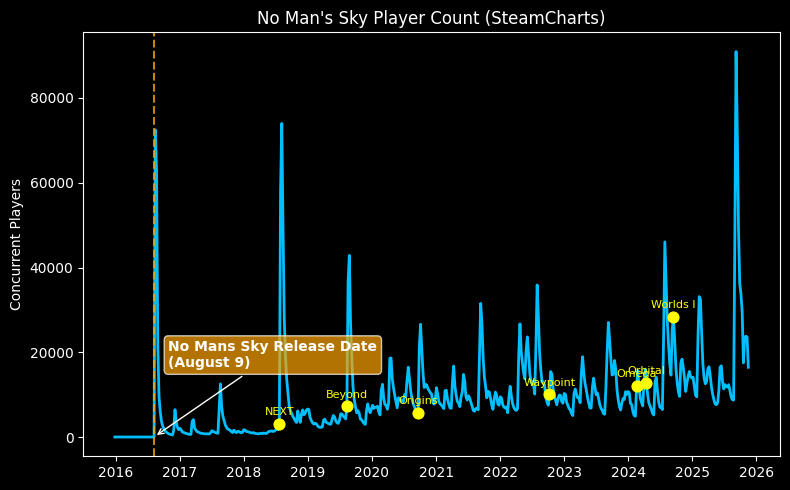

In [51]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title("No Man's Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")

# Zoom in on a date range — e.g., focus on the last 6–8 months
#start = pd.Timestamp("2016-12-24")
end = pd.Timestamp("2025-10-10")
#ax.set_xlim(start, end)

# Optionally smooth the data to reduce noise near the end
smooth = noman_df.resample("W").mean()

events = {
    "2018-07-24": "NEXT",
    "2019-08-14": "Beyond",
    "2020-09-23": "Origins",
    "2022-10-07": "Waypoint",
    "2024-02-15": "Omega",
    "2024-04-17": "Orbital",
    "2024-09-18": "Worlds I",
}
event_dates = {pd.Timestamp(k): v for k, v in events.items()}

ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

for date, label in event_dates.items():
    # find nearest existing date in your index
    nearest = smooth.index[smooth.index.get_indexer([date], method="nearest")[0]]

    ax.scatter(nearest, smooth.loc[nearest, "Players"],
               color="yellow", s=60, zorder=5)

    # small text right above the point (optional)
    ax.text(nearest, smooth.loc[nearest, "Players"] + 2000,
            label, color="yellow", fontsize=8, ha="center")


# annotate release date
noman_releasedate = pd.Timestamp("2016-08-09")
ax.axvline(x=noman_releasedate, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
ax.annotate('No Mans Sky Release Date\n(August 9)',
            xy=(noman_releasedate, close_filtered['positive_percent_smooth'].max()),
            xytext=(10, 50), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='white'),
            color='white', fontweight='bold')

plt.tight_layout()
plt.show()

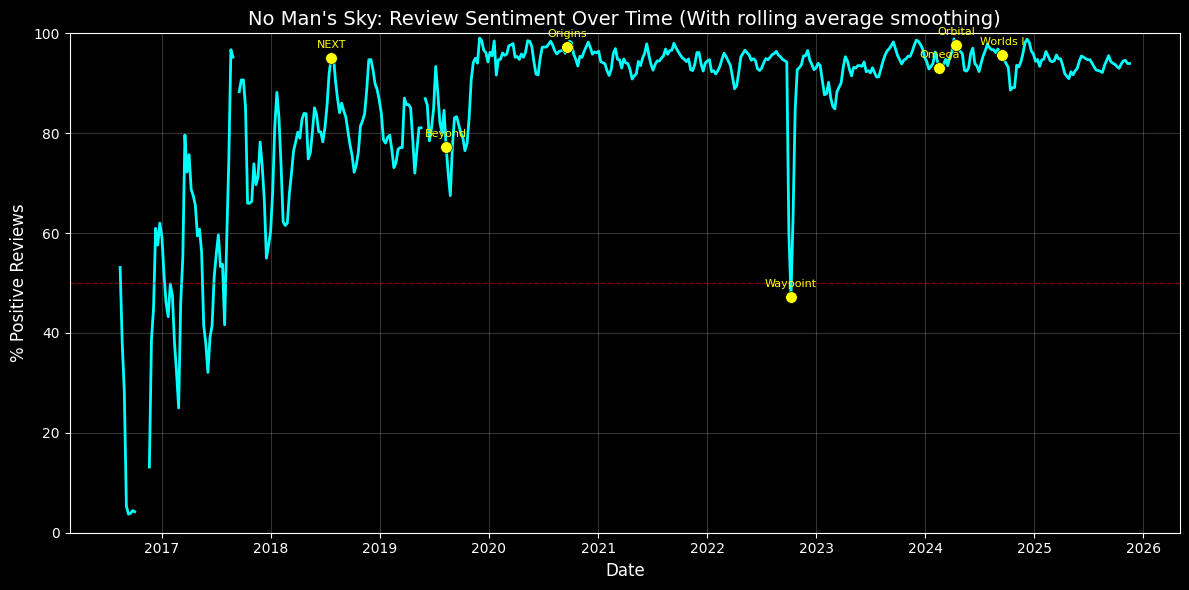

In [52]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

nomanreviews_df= nomanreviews_df.resample("W").mean()
pos_avg = nomanreviews_df['Positive reviews'].mean()
neg_avg = nomanreviews_df['Negative reviews'].abs().mean()

# Replace zeros with the averages
nomanreviews_df['Positive reviews'] = nomanreviews_df['Positive reviews'].replace(0, pos_avg)
nomanreviews_df['Negative reviews'] = nomanreviews_df['Negative reviews'].replace(0, -neg_avg)
# Calculate percentage
nomanreviews_df['positive_percent'] = (nomanreviews_df['Positive reviews'] /
                                     (nomanreviews_df['Positive reviews'] +
                                      nomanreviews_df['Negative reviews'].abs()) * 100)
# replace zeros with 50%
#close_filtered['positive_percent'] = close_filtered['positive_percent'].replace(0, 50.0)
# Apply rolling average to smooth the line
nomanreviews_df['positive_percent_smooth'] = nomanreviews_df['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()


for date, label in event_dates.items():
    # Find the nearest existing index value
    nearest = nomanreviews_df.index[nomanreviews_df.index.get_indexer([date], method="nearest")[0]]

    # Plot yellow dot
    ax.scatter(
        nearest,
        nomanreviews_df.loc[nearest, "positive_percent_smooth"],
        color="yellow",
        s=70,
        zorder=10,
        edgecolor="black",
        linewidth=0.4
    )
    ax.text(
        nearest,
        nomanreviews_df.loc[nearest, "positive_percent_smooth"] + 2,
        label,
        color="yellow",
        fontsize=8,
        ha="center"
    )


# Plot the smoothed version
ax.plot(nomanreviews_df.index, nomanreviews_df['positive_percent_smooth'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('No Man\'s Sky: Review Sentiment Over Time (With rolling average smoothing)', fontsize=14)
ax.set_ylim(0, 100)


ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Exhibit C: For Honor's Launch Disaster

This is one of the most unique fighting games with a very interesting combat system.

In [53]:
forhonor_id = 304390
forhonor_csv = "ForHonorPlayerCount.csv"
forhonor_df = pd.read_csv(forhonor_csv)

forhonorreviews_csv = "ForHonorreviews.csv"
forhonorreviews_df = pd.read_csv(forhonorreviews_csv)


forhonor_df.fillna(0.0, inplace=True) # fill empty rows with 0s
forhonor_df['DateTime'] = pd.to_datetime(forhonor_df['DateTime']) # change it ro real datetime
forhonor_df.set_index('DateTime', inplace=True)


forhonorreviews_df['Negative reviews'] = forhonorreviews_df['Negative reviews'].abs() # Make the negatives absolute
forhonorreviews_df['DateTime'] = pd.to_datetime(forhonorreviews_df['DateTime'])  # rea; datetime as well
forhonorreviews_df = forhonorreviews_df.dropna(subset=['DateTime'])
forhonorreviews_df = forhonorreviews_df.sort_values('DateTime')
forhonorreviews_df.set_index('DateTime', inplace=True)

print(forhonor_df.head()) # proof
print("--------------------------------")
print(forhonorreviews_df.head())

            Players  Average Players
DateTime                            
2016-06-21      1.0              0.0
2016-06-22      0.0              0.0
2016-06-23      0.0              0.0
2016-06-24      0.0              0.0
2016-06-25      0.0              0.0
--------------------------------
            Positive reviews  Negative reviews
DateTime                                      
2017-02-14              94.0              22.0
2017-02-15            1273.0             404.0
2017-02-16            1044.0             518.0
2017-02-17             664.0             463.0
2017-02-18             604.0             514.0


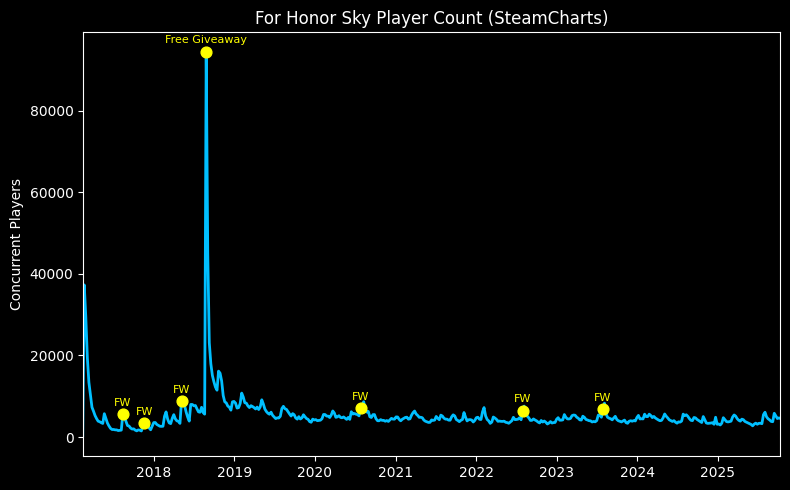

In [54]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title("For Honor Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")

# Zoom in on a date range — e.g., focus on the last 6–8 months
start = pd.Timestamp("2017-02-14")
end = pd.Timestamp("2025-10-10")
ax.set_xlim(start, end)

# Optionally smooth the data to reduce noise near the end
smooth = forhonor_df.resample("W").mean()

events = {
    "2017-08-10": "FW",
    "2017-11-17": "FW",
    "2018-05-03": "FW",
    "2018-08-27": "Free Giveaway",
    "2020-07-23": "FW",
    "2022-07-28": "FW",
    "2023-07-27": "FW"
}
event_dates = {pd.Timestamp(k): v for k, v in events.items()}

ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

for date, label in event_dates.items():
    # find nearest existing date in your index
    nearest = smooth.index[smooth.index.get_indexer([date], method="nearest")[0]]

    ax.scatter(nearest, smooth.loc[nearest, "Players"],
               color="yellow", s=60, zorder=5)

    # small text right above the point (optional)
    ax.text(nearest, smooth.loc[nearest, "Players"] + 2000,
            label, color="yellow", fontsize=8, ha="center")


# # annotate release date
# noman_releasedate = pd.Timestamp("2016-08-09")
# ax.axvline(x=noman_releasedate, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
# ax.annotate('No Mans Sky Release Date\n(August 9)',
#             xy=(noman_releasedate, close_filtered['positive_percent_smooth'].max()),
#             xytext=(10, 50), textcoords='offset points',
#             bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
#             arrowprops=dict(arrowstyle='->', color='white'),
#             color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Let's zoom into after the huge random spike

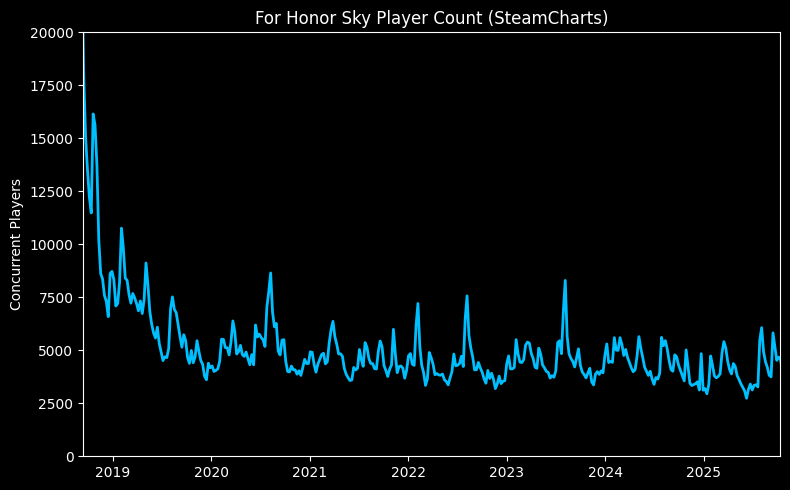

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))

start = pd.Timestamp("2018-09-14")
end = pd.Timestamp("2025-10-10")
ax.set_xlim(start, end)
ax.set_ylim(0, 20000)
ax.set_title("For Honor Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")
ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

plt.tight_layout()
plt.show()

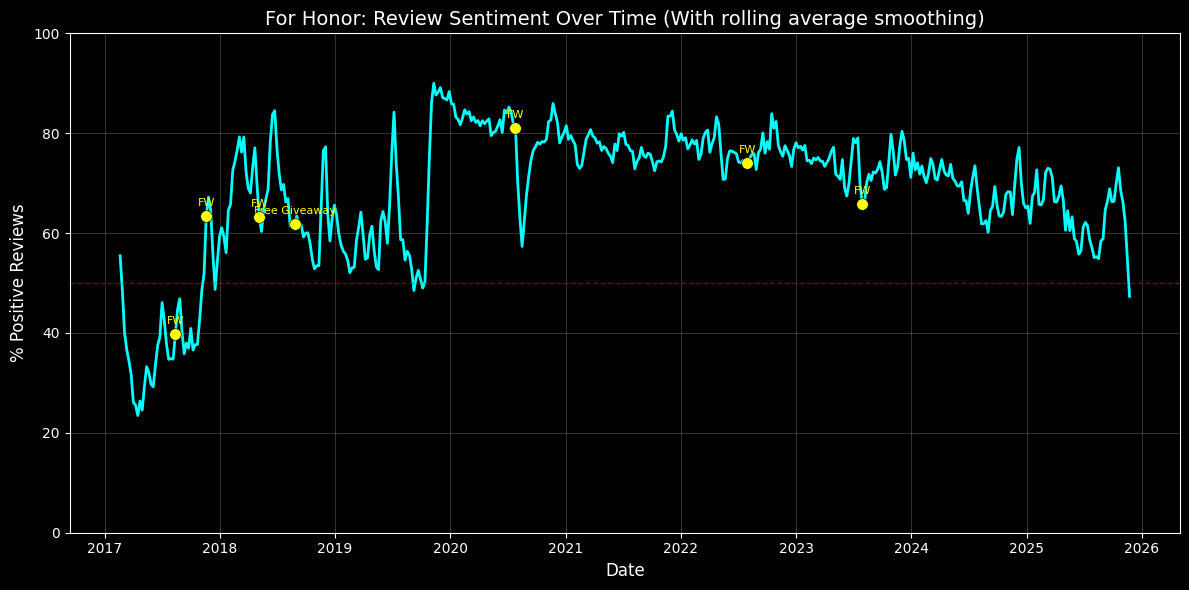

In [56]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

forhonorreviews_df= forhonorreviews_df.resample("W").mean()
pos_avg = forhonorreviews_df['Positive reviews'].mean()
neg_avg = forhonorreviews_df['Negative reviews'].abs().mean()

# Replace zeros with the averages
forhonorreviews_df['Positive reviews'] = forhonorreviews_df['Positive reviews'].replace(0, pos_avg)
forhonorreviews_df['Negative reviews'] = forhonorreviews_df['Negative reviews'].replace(0, -neg_avg)
# Calculate percentage
forhonorreviews_df['positive_percent'] = (forhonorreviews_df['Positive reviews'] /
                                     (forhonorreviews_df['Positive reviews'] +
                                      forhonorreviews_df['Negative reviews'].abs()) * 100)
# replace zeros with 50%
#close_filtered['positive_percent'] = close_filtered['positive_percent'].replace(0, 50.0)
# Apply rolling average to smooth the line
forhonorreviews_df['positive_percent_smooth'] = forhonorreviews_df['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()


for date, label in event_dates.items():
    # Find the nearest existing index value
    nearest = forhonorreviews_df.index[forhonorreviews_df.index.get_indexer([date], method="nearest")[0]]

    # Plot yellow dot
    ax.scatter(
        nearest,
        forhonorreviews_df.loc[nearest, "positive_percent_smooth"],
        color="yellow",
        s=70,
        zorder=10,
        edgecolor="black",
        linewidth=0.4
    )
    ax.text(
        nearest,
        forhonorreviews_df.loc[nearest, "positive_percent_smooth"] + 2,
        label,
        color="yellow",
        fontsize=8,
        ha="center"
    )


# Plot the smoothed version
ax.plot(forhonorreviews_df.index, forhonorreviews_df['positive_percent_smooth'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('For Honor: Review Sentiment Over Time (With rolling average smoothing)', fontsize=14)
ax.set_ylim(0, 100)


ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### This was enthralling to look at... With each free weekend followed a wave of negative reviews for the most part.

This is likely due to the nature of the game, and how overwhelming it can be for new players to face veterans. So a game like this, despite getting tons of fixes since release, has created a niche, loyal playerbase that is difficult to pick up in the middle. It's essentially trying to hop into a car driving down the road at 50 mph and expecting it to go successfully.

# Exhibit B: Warframe catastrophic update and "Censorship"

This is one of the cleanest examples of a successful live-service game dropping a huge, hyped update that detonated on impact and caused severe community backlash.

In [57]:
warframe_id = 230410
warframepplayers_csv = "WarframePlayerCount.csv"
warframe_df = pd.read_csv(warframepplayers_csv)

warframereviews_csv = "WarframeReviews.csv"
warframereviews_df = pd.read_csv(warframereviews_csv)


warframe_df.fillna(0.0, inplace=True) # fill empty rows with 0s
warframe_df['DateTime'] = pd.to_datetime(warframe_df['DateTime']) # change it ro real datetime
warframe_df.set_index('DateTime', inplace=True)


warframereviews_df.fillna(0.0, inplace=True) # fill empty rows with 0s
warframereviews_df['Negative reviews'] = warframereviews_df['Negative reviews'].abs() # Make the negatives absolute
warframereviews_df['DateTime'] = pd.to_datetime(warframereviews_df['DateTime'])  # rea; datetime as well
warframereviews_df = warframereviews_df.dropna(subset=['DateTime'])
warframereviews_df = warframereviews_df.sort_values('DateTime')
warframereviews_df.set_index('DateTime', inplace=True)

print(warframe_df.head()) # proof
print("--------------------------------")
print(warframereviews_df.head())

            Players  Average Players
DateTime                            
2013-02-01      1.0              0.0
2013-02-02      0.0              0.0
2013-02-03      0.0              0.0
2013-02-04      0.0              0.0
2013-02-05      0.0              0.0
--------------------------------
            Positive reviews  Negative reviews
DateTime                                      
2015-05-13               0.0               0.0
2015-05-14              19.0               5.0
2015-05-15             130.0              23.0
2015-05-16              67.0              11.0
2015-05-17             109.0              17.0


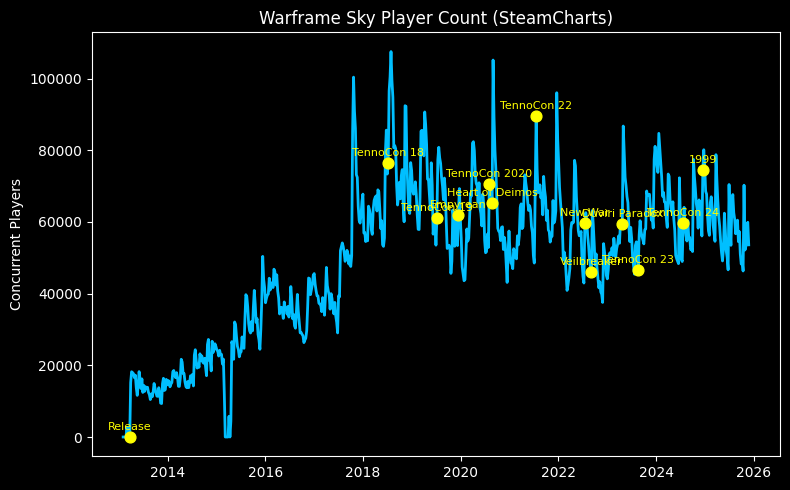

In [58]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title("Warframe Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")


# Optionally smooth the data to reduce noise near the end
smooth = warframe_df.resample("W").mean()

events = {
    "2013-03-25": "Release",
    "2018-07-08": "TennoCon 18",
    "2019-07-06": "TennoCon 19",
    "2019-12-13": "Empyrean",
    "2020-08-01": "TennoCon 2020",
    "2020-08-25": "Heart of Deimos",
    "2021-07-17": "TennoCon 22",
    "2022-07-16": "New War",
    "2022-09-07": "Veilbreaker",
    "2023-04-26": "Duviri Paradox",
    "2023-08-23": "TennoCon 23",
    "2024-07-20": "TennoCon 24",
    "2024-12-13": "1999",
}
event_dates = {pd.Timestamp(k): v for k, v in events.items()}

ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

for date, label in event_dates.items():
    # find nearest existing date in your index
    nearest = smooth.index[smooth.index.get_indexer([date], method="nearest")[0]]

    ax.scatter(nearest, smooth.loc[nearest, "Players"],
               color="yellow", s=60, zorder=5)

    # small text right above the point (optional)
    ax.text(nearest, smooth.loc[nearest, "Players"] + 2000,
            label, color="yellow", fontsize=8, ha="center")


# # annotate release date
# noman_releasedate = pd.Timestamp("2016-08-09")
# ax.axvline(x=noman_releasedate, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
# ax.annotate('No Mans Sky Release Date\n(August 9)',
#             xy=(noman_releasedate, close_filtered['positive_percent_smooth'].max()),
#             xytext=(10, 50), textcoords='offset points',
#             bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
#             arrowprops=dict(arrowstyle='->', color='white'),
#             color='white', fontweight='bold')

plt.tight_layout()
plt.show()

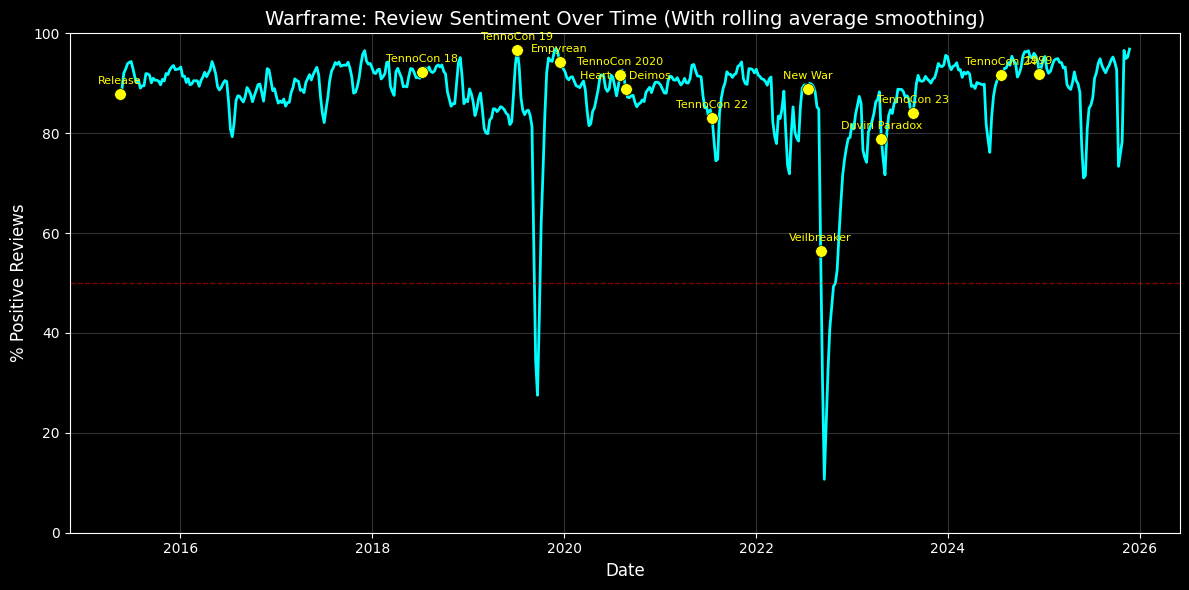

In [59]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))


warframereviews_df= warframereviews_df.resample("W").mean()
pos_avg = warframereviews_df['Positive reviews'].mean()
neg_avg = warframereviews_df['Negative reviews'].abs().mean()

# Replace zeros with the averages
warframereviews_df['Positive reviews'] = warframereviews_df['Positive reviews'].replace(0, pos_avg)
warframereviews_df['Negative reviews'] = warframereviews_df['Negative reviews'].replace(0, -neg_avg)
# Calculate percentage
warframereviews_df['positive_percent'] = (warframereviews_df['Positive reviews'] /
                                     (warframereviews_df['Positive reviews'] +
                                      warframereviews_df['Negative reviews'].abs()) * 100)
# replace zeros with 50%
#close_filtered['positive_percent'] = close_filtered['positive_percent'].replace(0, 50.0)
# Apply rolling average to smooth the line
warframereviews_df['positive_percent_smooth'] = warframereviews_df['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()


for date, label in event_dates.items():
    # Find the nearest existing index value
    nearest = warframereviews_df.index[warframereviews_df.index.get_indexer([date], method="nearest")[0]]

    # Plot yellow dot
    ax.scatter(
        nearest,
        warframereviews_df.loc[nearest, "positive_percent_smooth"],
        color="yellow",
        s=70,
        zorder=10,
        edgecolor="black",
        linewidth=0.4
    )
    ax.text(
        nearest,
        warframereviews_df.loc[nearest, "positive_percent_smooth"] + 2,
        label,
        color="yellow",
        fontsize=8,
        ha="center"
    )


# Plot the smoothed version
ax.plot(warframereviews_df.index, warframereviews_df['positive_percent_smooth'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Warframe: Review Sentiment Over Time (With rolling average smoothing)', fontsize=14)
ax.set_ylim(0, 100)


ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

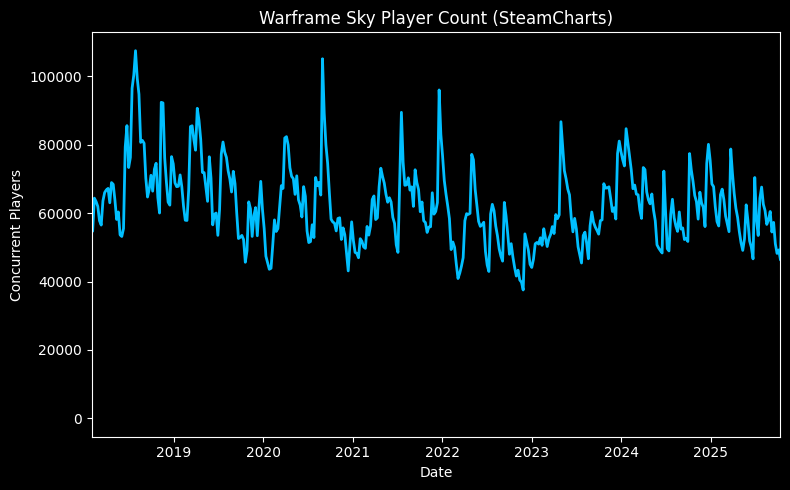

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))

start = pd.Timestamp("2018-02-01")
end = pd.Timestamp("2025-10-10")
ax.set_xlim(start, end)
ax.set_title("Warframe Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")
ax.set_xlabel("Date")
ax.plot(smooth.index, smooth["Players"], color="deepskyblue", linewidth=2)

plt.tight_layout()
plt.show()

### Calculating the recovery metrics for these games

So we see the huge impact that these games experience when these updates/launches are below expectations. The next part of my research is how this impacts the game's recovery from these updates.

In [61]:
def load_and_prepare_reviews(csv_path):
    """
    Load raw review CSV and prepare it for analysis
    Expects columns: DateTime, Positive reviews, Negative reviews
    """
    # Load the CSV
    df = pd.read_csv(csv_path)

    # Convert DateTime to pandas datetime
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df = df.set_index('DateTime')
    df = df.sort_index()

    # Make negative reviews positive
    df['Negative reviews'] = df['Negative reviews'].abs()

    # Resample to weekly average
    df = df.resample("W").mean()

    # Calculate averages for filling NaN/zero values
    pos_avg = df[df['Positive reviews'] > 0]['Positive reviews'].mean()
    neg_avg = df[df['Negative reviews'] > 0]['Negative reviews'].mean()

    # Fill NaN values
    df['Positive reviews'] = df['Positive reviews'].fillna(pos_avg)
    df['Negative reviews'] = df['Negative reviews'].fillna(neg_avg)

    # Replace remaining zeros
    df.loc[df['Positive reviews'] == 0, 'Positive reviews'] = pos_avg
    df.loc[df['Negative reviews'] == 0, 'Negative reviews'] = neg_avg

    # Calculate positive percentage
    total_reviews = df['Positive reviews'] + df['Negative reviews']
    df['positive_percent'] = (df['Positive reviews'] / total_reviews * 100).fillna(50.0)

    # Apply rolling average for smoothing
    df['positive_percent_smooth'] = (
        df['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()
    )

    return df

def calculate_recovery_metrics(reviews_df, event_info):
    """
    Calculate recovery speed metrics for a crisis event
    Expects reviews_df to already be processed with positive_percent_smooth column
    """
    start_date = pd.to_datetime(event_info['start'])
    end_date = pd.to_datetime(event_info['end'])

    # Filter to event period
    mask = (reviews_df.index >= start_date) & (reviews_df.index <= end_date)
    period_data = reviews_df[mask].copy()

    actual_bottom = period_data['positive_percent_smooth'].idxmin()
    bottom_date = actual_bottom
    bottom_value = period_data.loc[actual_bottom, 'positive_percent_smooth']

    if len(period_data) == 0:
        print(f"Warning: No data found for {event_info['name']}")
        return None, None, None

    # Get key values
    start_value = period_data['positive_percent_smooth'].iloc[0]
    bottom_value = period_data['positive_percent_smooth'].min()
    end_value = period_data['positive_percent_smooth'].iloc[-1]

    # Calculate metrics
    total_drop = start_value - bottom_value
    total_recovery = end_value - bottom_value
    recovery_percentage = (total_recovery / total_drop * 100) if total_drop != 0 else 0

    # Time calculations
    time_to_bottom = (bottom_date - start_date).days
    time_to_recovery = (end_date - bottom_date).days

    # Recovery rate (per day)
    recovery_rate = total_recovery / time_to_recovery if time_to_recovery > 0 else 0

    # Calculate linear slope for recovery phase
    recovery_data = period_data[period_data.index >= bottom_date].copy()
    recovery_data['days_since_bottom'] = (
        recovery_data.index - bottom_date
    ).total_seconds() / (24 * 3600)

    if len(recovery_data) > 1:
        # Remove any NaN values before regression
        clean_data = recovery_data[['days_since_bottom', 'positive_percent_smooth']].dropna()
        if len(clean_data) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                clean_data['days_since_bottom'],
                clean_data['positive_percent_smooth']
            )
        else:
            slope, r_value = 0, 0
    else:
        slope, r_value = 0, 0

    # Half-life calculation
    half_recovery_value = bottom_value + (total_drop * 0.5)
    half_life_data = recovery_data[recovery_data['positive_percent_smooth'] >= half_recovery_value]
    if len(half_life_data) > 0:
        half_life_days = (half_life_data.index.min() - bottom_date).days
    else:
        half_life_days = None

    results = {
        'event': event_info['name'],
        'start_value': start_value,
        'bottom_value': bottom_value,
        'end_value': end_value,
        'total_drop': total_drop,
        'total_recovery': total_recovery,
        'recovery_percentage': recovery_percentage,
        'time_to_bottom_days': time_to_bottom,
        'time_to_recovery_days': time_to_recovery,
        'recovery_rate_per_day': recovery_rate,
        'linear_slope': slope,
        'r_squared': r_value**2,
        'half_life_days': half_life_days
    }

    return results, period_data, recovery_data

def print_recovery_results(results):
    """
    Print recovery metrics in a formatted way
    """
    print(f"\n{results['event']}")
    print("-" * 60)
    print(f"Start Sentiment: {results['start_value']:.2f}%")
    print(f"Bottom Sentiment: {results['bottom_value']:.2f}%")
    print(f"End Sentiment: {results['end_value']:.2f}%")
    print(f"Total Drop: {results['total_drop']:.2f}%")
    print(f"Total Recovery: {results['total_recovery']:.2f}%")
    print(f"Recovery Percentage: {results['recovery_percentage']:.1f}%")
    print(f"Time to Bottom: {results['time_to_bottom_days']} days")
    print(f"Time to Recovery: {results['time_to_recovery_days']} days")
    print(f"Recovery Rate: {results['recovery_rate_per_day']:.3f}% per day")
    print(f"Linear Slope: {results['linear_slope']:.4f}")
    print(f"R-squared: {results['r_squared']:.3f}")
    if results['half_life_days']:
        print(f"Half-Life: {results['half_life_days']} days")

def plot_recovery_analysis(crisis_events, reviews_df, game_name):
    """
    Create visualization of recovery with slopes
    """
    plt.style.use("dark_background")
    fig, axes = plt.subplots(len(crisis_events), 1,
                            figsize=(12, 6 * len(crisis_events)))

    if len(crisis_events) == 1:
        axes = [axes]

    for idx, (event_key, event_info) in enumerate(crisis_events.items()):
        ax = axes[idx]

        results, period_data, recovery_data = calculate_recovery_metrics(
            reviews_df, event_info
        )

        if not results:
            continue

        # Plot actual data
        ax.plot(period_data.index, period_data['positive_percent_smooth'],
                marker='o', linewidth=2, label='Actual Sentiment',
                color='cyan', markersize=4)

        # Plot linear regression line for recovery phase
        if len(recovery_data) > 1 and results['linear_slope'] != 0:
            slope = results['linear_slope']

            # Generate regression line
            days = recovery_data['days_since_bottom']
            regression_line = slope * days + results['bottom_value']

            ax.plot(recovery_data.index, regression_line,
                    linestyle='--', linewidth=2, color='orange',
                    label=f'Linear Fit (slope={slope:.4f}/day, R²={results["r_squared"]:.3f})')

        # Mark key points
        bottom_idx = period_data['positive_percent_smooth'].idxmin()
        ax.axvline(bottom_idx, color='red', linestyle=':',
                   alpha=0.7, label='Bottom')
        ax.scatter([bottom_idx], [results['bottom_value']],
                   color='red', s=100, zorder=5)

        # Add annotations
        annotation_text = (
            f"Recovery Rate: {results['recovery_rate_per_day']:.3f}%/day\n"
            f"Total Recovery: {results['recovery_percentage']:.1f}%\n"
            f"Time: {results['time_to_recovery_days']} days"
        )
        ax.text(0.02, 0.98, annotation_text,
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Positive Review %', fontsize=12)
        ax.set_title(f'{game_name} - {results["event"]}: Recovery Analysis',
                     fontsize=14, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

def analyze_game_recovery(csv_path, crisis_events, game_name):
    """
    Complete recovery analysis for a game from raw CSV
    """
    print("=" * 60)
    print(f"{game_name.upper()} RECOVERY ANALYSIS")
    print("=" * 60)

    # Load and prepare the data
    print(f"\nLoading data from {csv_path}...")
    reviews_df = load_and_prepare_reviews(csv_path)
    print(f"Loaded {len(reviews_df)} weeks of review data")

    results_list = []

    for event_key, event_info in crisis_events.items():
        results, period_data, recovery_data = calculate_recovery_metrics(
            reviews_df, event_info
        )

        if results:
            results_list.append(results)
            print_recovery_results(results)

    # Create summary DataFrame
    if results_list:
        results_df = pd.DataFrame(results_list)
        print("\n" + "=" * 60)
        print("COMPARISON SUMMARY")
        print("=" * 60)
        print(results_df.to_string(index=False))

        # Create visualizations
        plot_recovery_analysis(crisis_events, reviews_df, game_name)

    print("\n" + "=" * 60)
    print("Analysis Complete!")
    print("=" * 60)

    return results_df if results_list else None


HELLDIVERS 2 RECOVERY ANALYSIS

Loading data from Helldivers2SteamCharts.csv...
Loaded 93 weeks of review data

PSN Account Controversy
------------------------------------------------------------
Start Sentiment: 59.96%
Bottom Sentiment: 36.84%
End Sentiment: 71.39%
Total Drop: 23.13%
Total Recovery: 34.56%
Recovery Percentage: 149.4%
Time to Bottom: 11 days
Time to Recovery: 49 days
Recovery Rate: 0.705% per day
Linear Slope: 0.5936
R-squared: 0.505
Half-Life: 7 days

COMPARISON SUMMARY
                  event  start_value  bottom_value  end_value  total_drop  total_recovery  recovery_percentage  time_to_bottom_days  time_to_recovery_days  recovery_rate_per_day  linear_slope  r_squared  half_life_days
PSN Account Controversy    59.963639     36.838081  71.394271   23.125557        34.55619            149.42857                   11                     49               0.705228      0.593636   0.505455               7


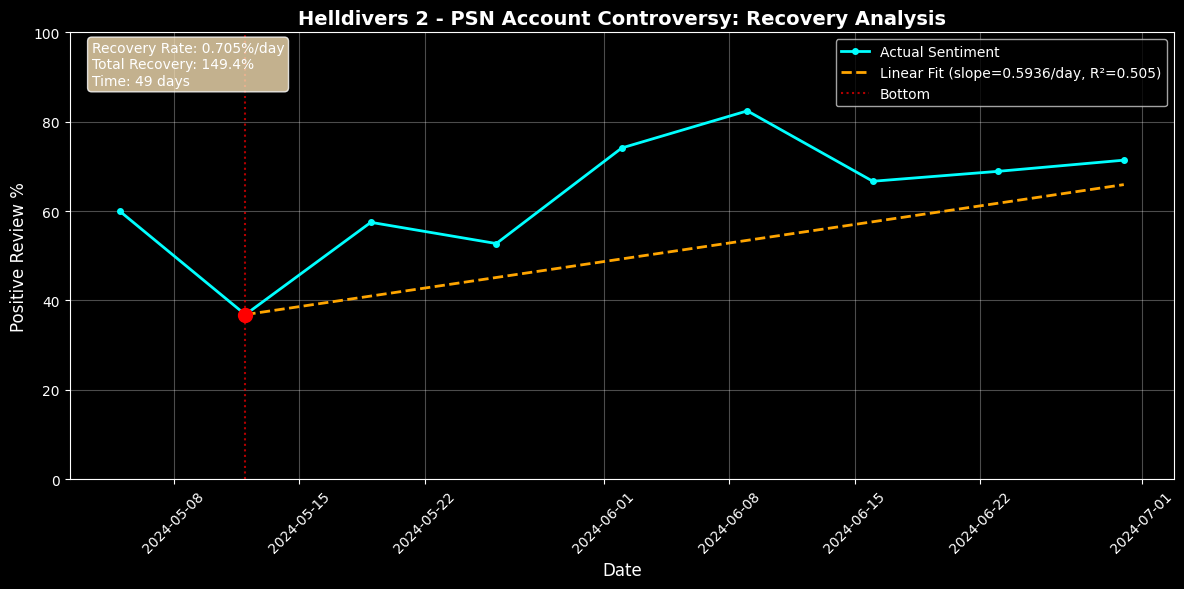


Analysis Complete!


In [62]:
# Try expanding your time window
helldivers_crisis_events = {
    'psn_controversy': {
        'name': 'PSN Account Controversy',
        'start': '2024-05-01',  # Start earlier
        'bottom': '2024-05-05',
        'end': '2024-06-30',    # Extend further
    }
}

helldivers_results = analyze_game_recovery(
    'Helldivers2SteamCharts.csv',
    helldivers_crisis_events,
    "Helldivers 2"
)

NO MAN'S SKY RECOVERY ANALYSIS

Loading data from NoMansSkyReviews.csv...
Loaded 484 weeks of review data

Launch Disaster
------------------------------------------------------------
Start Sentiment: 53.13%
Bottom Sentiment: 3.89%
End Sentiment: 95.12%
Total Drop: 49.24%
Total Recovery: 91.23%
Recovery Percentage: 185.3%
Time to Bottom: 40 days
Time to Recovery: 674 days
Recovery Rate: 0.135% per day
Linear Slope: 0.0688
R-squared: 0.576
Half-Life: 21 days

NEXT Update Recovery
------------------------------------------------------------
Start Sentiment: 95.83%
Bottom Sentiment: 43.19%
End Sentiment: 95.47%
Total Drop: 52.64%
Total Recovery: 52.28%
Recovery Percentage: 99.3%
Time to Bottom: 278 days
Time to Recovery: 839 days
Recovery Rate: 0.062% per day
Linear Slope: 0.0238
R-squared: 0.348
Half-Life: 35 days

COMPARISON SUMMARY
               event  start_value  bottom_value  end_value  total_drop  total_recovery  recovery_percentage  time_to_bottom_days  time_to_recovery_days  rec

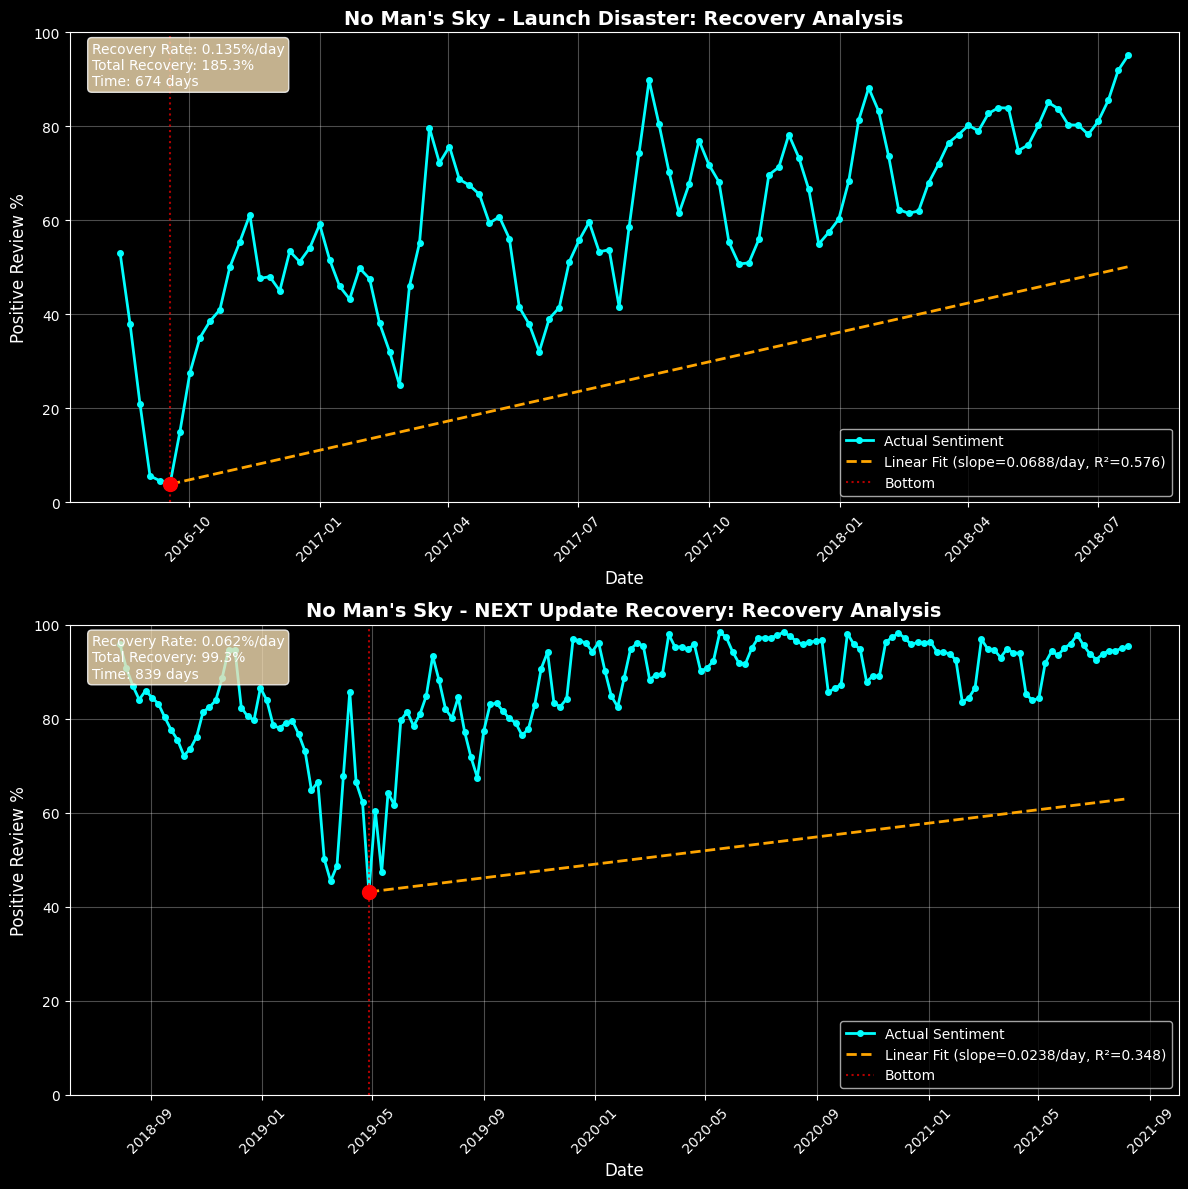


Analysis Complete!


In [63]:
nms_crisis_events = {
    'launch_disaster': {
        'name': 'Launch Disaster',
        'start': '2016-08-09',
        'bottom': '2016-08-15',
        'end': '2018-07-24',
    },
    'next_update': {
        'name': 'NEXT Update Recovery',
        'start': '2018-07-24',
        'bottom': '2019-02-14',
        'end': '2021-08-14',
    }
}

nms_results = analyze_game_recovery(
    'NoMansSkyReviews.csv',  # Path to your CSV
    nms_crisis_events,
    "No Man's Sky"
)

FOR HONOR RECOVERY ANALYSIS

Loading data from ForHonorreviews.csv...
Loaded 458 weeks of review data

Launch Issues
------------------------------------------------------------
Start Sentiment: 55.45%
Bottom Sentiment: 23.47%
End Sentiment: 34.77%
Total Drop: 31.98%
Total Recovery: 11.30%
Recovery Percentage: 35.3%
Time to Bottom: 61 days
Time to Recovery: 116 days
Recovery Rate: 0.097% per day
Linear Slope: 0.1258
R-squared: 0.532
Half-Life: 77 days

Game Growth
------------------------------------------------------------
Start Sentiment: 71.45%
Bottom Sentiment: 60.18%
End Sentiment: 64.47%
Total Drop: 11.27%
Total Recovery: 4.30%
Recovery Percentage: 38.1%
Time to Bottom: 1461 days
Time to Recovery: 255 days
Recovery Rate: 0.017% per day
Linear Slope: 0.0087
R-squared: 0.030
Half-Life: 21 days

COMPARISON SUMMARY
        event  start_value  bottom_value  end_value  total_drop  total_recovery  recovery_percentage  time_to_bottom_days  time_to_recovery_days  recovery_rate_per_day  li

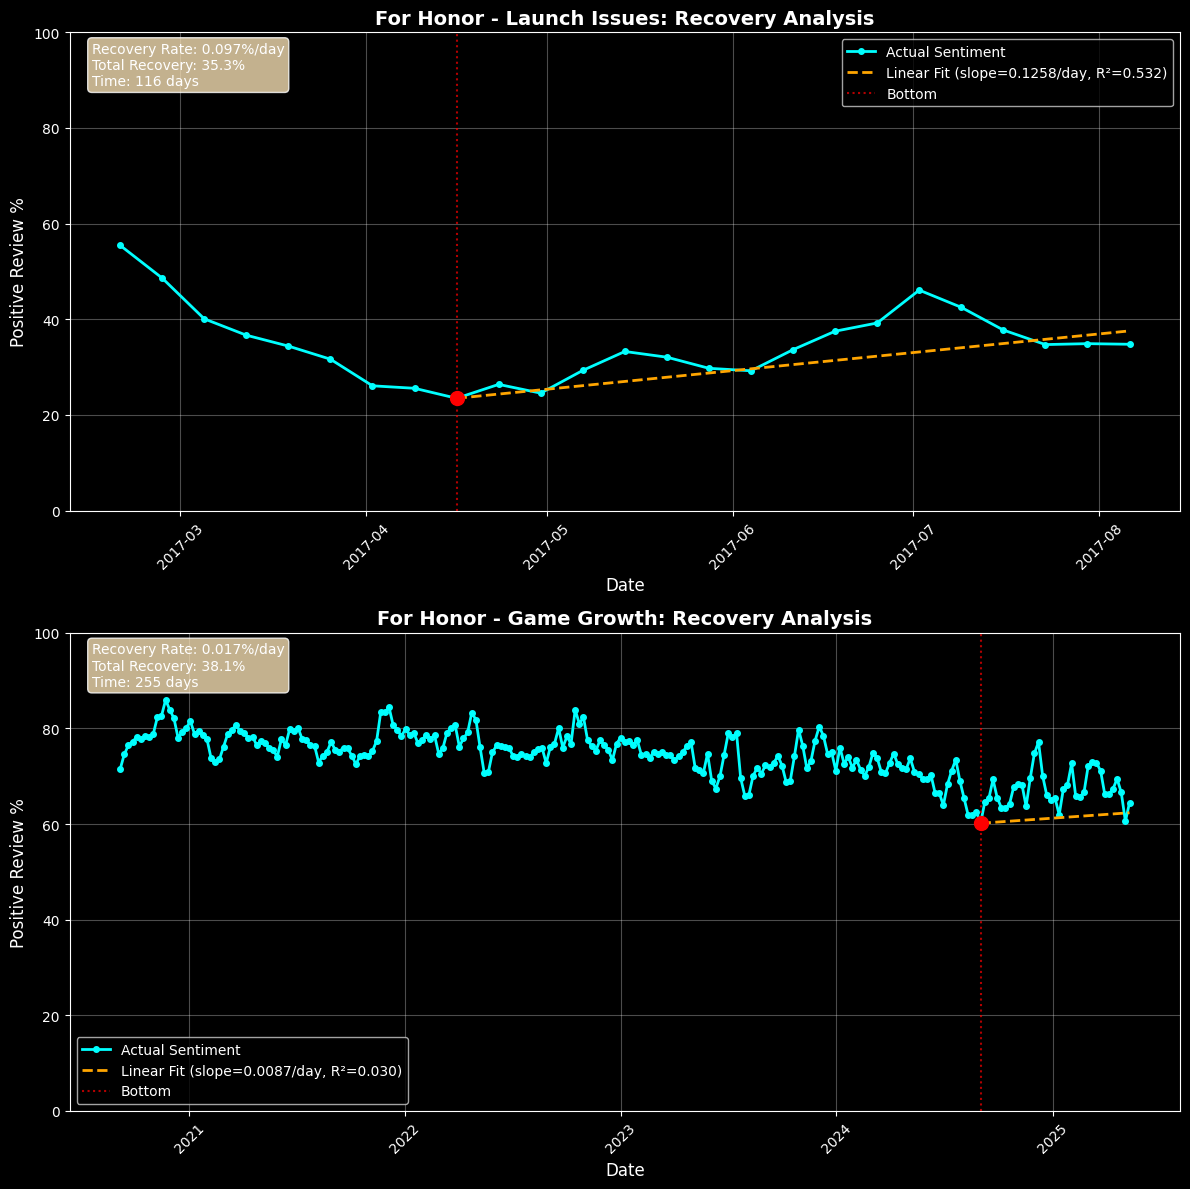


Analysis Complete!


In [64]:
forhonor_crisis_events = {
    'launch': {
        'name': 'Launch Issues',
        'start': '2017-02-14',
        'bottom': '2017-04-20',  # Adjusted to match the actual bottom
        'end': '2017-08-10',
    },
    'game_growth': {  # Fixed name (no space)
        'name': 'Game Growth',
        'start': '2020-09-01',
        'bottom': '2021-01-15',  # Changed from 2025 to 2020
        'end': '2025-05-14'      # Reasonable recovery window
    }
}
forhonor_results = analyze_game_recovery(
    'ForHonorreviews.csv',
    forhonor_crisis_events,
    "For Honor"
)

WARFRAME RECOVERY ANALYSIS

Loading data from WarframeReviews.csv...
Loaded 550 weeks of review data

Empyrean Update
------------------------------------------------------------
Start Sentiment: 84.79%
Bottom Sentiment: 30.97%
End Sentiment: 88.79%
Total Drop: 53.82%
Total Recovery: 57.82%
Recovery Percentage: 107.4%
Time to Bottom: 132 days
Time to Recovery: 338 days
Recovery Rate: 0.171% per day
Linear Slope: 0.0420
R-squared: 0.122
Half-Life: 14 days

COMPARISON SUMMARY
          event  start_value  bottom_value  end_value  total_drop  total_recovery  recovery_percentage  time_to_bottom_days  time_to_recovery_days  recovery_rate_per_day  linear_slope  r_squared  half_life_days
Empyrean Update    84.793409      30.96873  88.790829   53.824679         57.8221           107.426743                  132                    338               0.171071      0.042038   0.122411              14


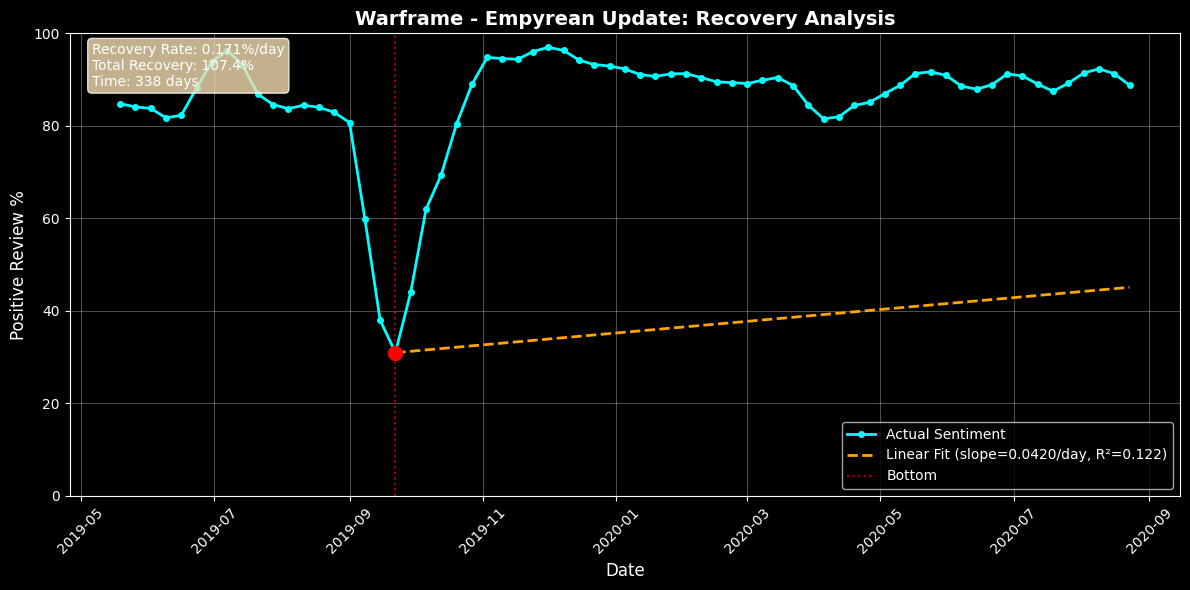


Analysis Complete!


In [67]:
warframe_crisis_events = {
    'empyrean': {
        'name': 'Empyrean Update',
        'start': '2019-05-13',
        'bottom': '2019-09-01',
        'end': '2020-08-25',
    }
}
warframe_results = analyze_game_recovery(
    'WarframeReviews.csv',
    warframe_crisis_events,
    "Warframe"
)